# Reinforcement Learning
Author: Jin Yeom (jinyeom@utexas.edu)

In [1]:
import gym
import numpy as np
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
%matplotlib inline

## Q-learning

Let's begin with the **Q-learning** algorithm, which is based on the following learning rule,

$$
Q'(s_t, a_t) \leftarrow (1 - \alpha)Q(s_t, a_t) + \alpha(r_t + \gamma \max_{a}Q(s_{t + 1}, a))
$$

which is often written rearranged for convenience, as follows

$$
Q'(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha(r_t + \gamma \max_{a}Q(s_{t + 1}, a) - Q(s_t, a_t))
$$

where the term $[r_t + \gamma \max_{a}Q(s_{t + 1}, a) - Q(s_t, a_t)]$ directly describes the "error" in Q values.

In [2]:
def update_Q(Q, s, a, r, s_, alpha, gamma):
    diff = r + gamma * np.max(Q[s_, :]) - Q[s, a]
    Q[s, a] = Q[s, a] + alpha * diff

In [3]:
def tabular_q_learning(q_table, env, alpha, gamma, epsilon, n_iter, n_eps):
    reward_log = []
    for ep in tqdm(range(n_eps)):
        s = env.reset()
        i = total_reward = done = 0
        while not done and i < n_iter:
            # ε-greedy is applied for exploration, in which by some probability ε,
            # a random action is chosen, instead of the reward maximizing action.
            a = np.random.choice([env.action_space.sample(), np.argmax(q_table[s, :])],
                                 p=[epsilon, 1 - epsilon])
            s_, r, done, _ = env.step(a)
            update_Q(q_table, s, a, r, s_, alpha, gamma)
            total_reward += r
            s = s_
            i += 1
        reward_log.append(total_reward)
    return reward_log

For this section, we're going to use a simple Grid World based environment called **Frozen Lake**.

In [162]:
env = gym.make("FrozenLake-v0")
print(env.observation_space)
print(env.action_space)

Discrete(16)
Discrete(4)


HBox(children=(IntProgress(value=0, max=3000), HTML(value='')))

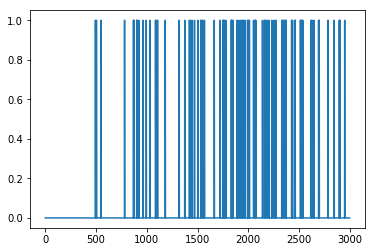

In [5]:
q_table = np.zeros((env.observation_space.n, env.action_space.n))
reward_log = tabular_q_learning(q_table, env, 0.8, 0.9, 0.5, 200, 3000)
plt.plot(reward_log)
plt.show()

## Approximate Q-learning and Deep Q-learning

In **Approximate Q-learning**, the Q-table is approximated by a linear function (namely, a Q-function) that maps some set of features that represents each state to its Q values. So, rather than starting with Q values of all zeros, we start with some approximation,

$$
Q(s, a) \approx \begin{bmatrix} w_1 & w_2 & ... & w_n \end{bmatrix} \cdot
                \begin{bmatrix} f_1(s, a) \\ f_2(s, a) \\ ... \\ f_n(s, a) \end{bmatrix}
$$

then adjust each weight according to the following rule,

$$
w \leftarrow w + \alpha (r_t + \gamma \max_{a}Q(s_{t + 1}, a) - Q(s_t, a_t)) f(s, a)
$$

Notice that the learning rule for approximate Q-learning is quite similar to tabular Q-learning, in which the difference ($r_t + \gamma \max_{a}Q(s_{t + 1}, a) - Q(s_t, a_t)$) in Q values is used to adjust the table. 

The following diagram describes our model for approximate Q-learning. A set of features is linearly transformed to output approximate Q-values for all actions, then softmax follows to compute the probability of each action.

![linear_softmax](images/linear_softmax.png)

In [188]:
env = gym.make("CartPole-v1")
print(env.observation_space)
print(env.action_space)

Box(4,)
Discrete(2)


In [189]:
def pred_Q(W, s):
    return np.dot(W, s)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def choose_action(W, s):
    # softmax is another method of exploration (other than ε-greedy), in which
    # probability of each action is computed, and the most probable action is
    # selected.
    probs = softmax(pred_Q(W, s))    
    return np.random.choice(np.arange(len(probs)), p=probs)

In [190]:
def update_W(W, s, a, r, s_, alpha, gamma):
    diff = r + gamma * np.amax(pred_Q(W, s_)) - pred_Q(W, s)[a]
    W[a, :] = W[a, :] + alpha * diff * s

In [191]:
def approx_q_learning(W, env, alpha, gamma, n_iter, n_eps):
    reward_log = []
    for ep in tqdm(range(n_eps)):
        s = env.reset()
        i = total_reward = done = 0
        while not done and i < n_iter:
            a = choose_action(W, s)
            s_, r, done, _ = env.step(a)
            update_W(W, s, a, r, s_, alpha, gamma)
            total_reward += r
            s = s_
            i += 1
        reward_log.append(total_reward)
    return reward_log

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

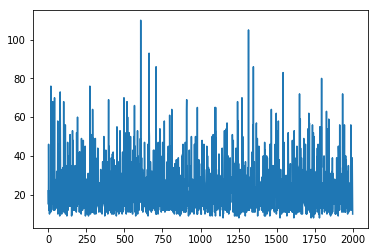

In [193]:
approx_q = np.random.normal(loc=0.0, scale=0.01, size=(env.action_space.n, env.observation_space.shape[0]))
reward_log = approx_q_learning(approx_q, env, 1e-4, 0.9, 200, 2000)
plt.plot(reward_log)
plt.show()

[[ 0.00952525  0.00692663  0.00924364 -0.05218079]
 [ 0.01244558  0.00874505  0.00998711 -0.02298688]]


## References
1. https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0
2. http://www.cs.utexas.edu/~sniekum/classes/343-S18/lectures/lecture12.pdf